In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((480, 12, 1), (480,))

In [8]:
X_train, y_train = X[:384], y[:384]
X_val, y_val = X[384:432], y[384:432]
X_test, y_test = X[432:], y[432:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
48/48 [==============================] - 38s 611ms/step - loss: 0.1499 - root_mean_squared_error: 0.3871 - val_loss: 0.0477 - val_root_mean_squared_error: 0.2185
Epoch 2/50
48/48 [==============================] - 25s 534ms/step - loss: 0.0895 - root_mean_squared_error: 0.2992 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1990
Epoch 3/50
48/48 [==============================] - 26s 549ms/step - loss: 0.0690 - root_mean_squared_error: 0.2627 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1764
Epoch 4/50
48/48 [==============================] - 27s 575ms/step - loss: 0.0465 - root_mean_squared_error: 0.2156 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1399
Epoch 5/50
48/48 [==============================] - 26s 554ms/step - loss: 0.0298 - root_mean_squared_error: 0.1725 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221
Epoch 6/50
48/48 [==============================] - 25s 537ms/step - loss: 0.0271 - root_mean_squared_error: 0.1646 - val_loss: 0.0130 

48/48 [==============================] - 3s 60ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1526
Epoch 41/50
48/48 [==============================] - 3s 63ms/step - loss: 0.0136 - root_mean_squared_error: 0.1165 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1661
Epoch 42/50
48/48 [==============================] - 3s 58ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.0322 - val_root_mean_squared_error: 0.1793
Epoch 43/50
48/48 [==============================] - 3s 56ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1755
Epoch 44/50
48/48 [==============================] - 3s 56ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1454
Epoch 45/50
48/48 [==============================] - 3s 65ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0300 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

6.025029242038727 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

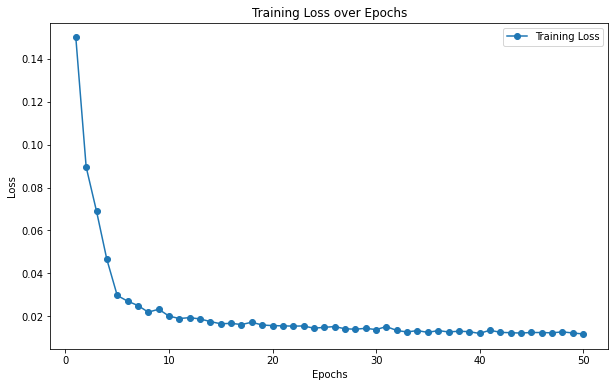

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

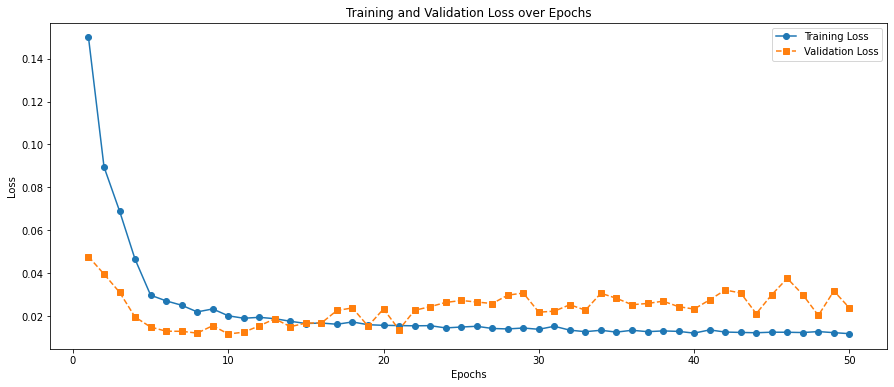

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 25ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.12239494551732771
MAE : 0.08483018988566327


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,-15833.314453,32185.203
1,-16237.444336,2490.551
2,15218.962891,1707.377
3,63746.480469,11293.282
4,129777.914062,49957.406
5,206936.921875,151973.751
6,285433.500000,466524.938
7,358598.187500,708542.184
8,343352.968750,652598.000
9,167073.171875,414216.785


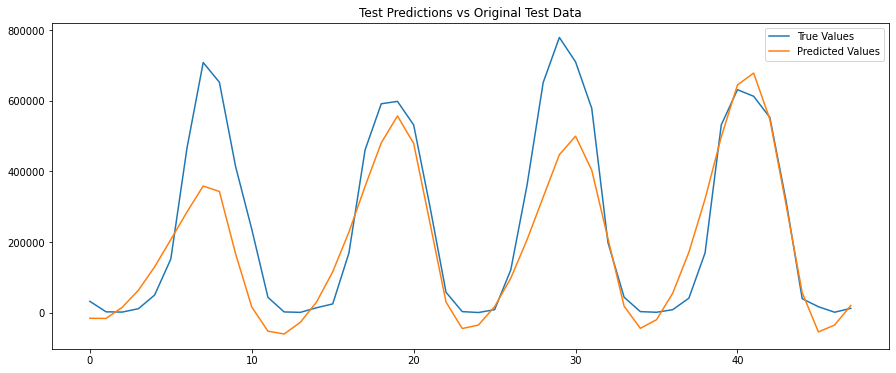

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 1s 40ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

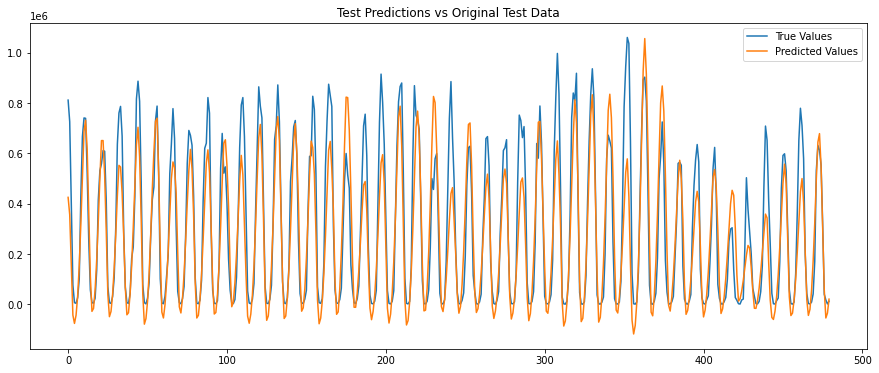

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()